<div align="center">
    <img src="https://images.unsplash.com/photo-1552288084-454d4fa5caa1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1954&q=80"  width="80%" />
    <h1>BATTLE OF THE NEIGHBORHOOD</h1>
    <h3>by Kurt Irvin M. Rojas</h3>
</div>

## A. INTRODUCTION

### A.1 Objective
Japanese cuisine is undoubtly one of most famous cuisine. However, from the perspective of an investor or a chef dreaming of opening his/her own japanese restaurant, it is a remarkable challenge in getting into the market due to the highly saturated supply of japanese food. 

The objective of this project is to find the best neighborhood in Toronto to open a Japanese restaurant. In this project, we'll be trying to create a projection on which place is best to start a japanese restaurant using Foursquare location data and clustering analysis. 

### A.2 Target Audience
* Japanese chef's trying to open their own restaurant.
* Investors looking to establish a business related to japanese food. 
* Tourists who are interested in Japanese cuisine. 

### A.3 Data Description 

1. **Basic Toronto City data**
- **Source**: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- **Description**: The wikipedia page containts the basic city data of Canada. From here, we can get the specific boroughs and neighborhoods, as well as its corresponding postal codes. 

2. **Geolocation data**
- **Source**: https://cocl.us/Geospatial_data
- **Description**: As the nominatim service is quite slow to use, a dataset is provided which contains the latitude and longitude of Postal codes. In the event that a latitude and longitude entry is not in the dataset, I used **google maps API** to check for the details. 

3. **Venue data**
- **Source**: https://foursquare.com/developers/apps
- **Description**: To explore each vicinity, we need some data about the various businesses local to the place. In this case, we query the foursquare API to see the local businesses. It returns the name, category and geolocation data of the establishments. This data is key in the analysis section where this data is used to create the clusters. 


## B. METHODOLOGY

### B.1. Libraries

In [1]:
# For webscraping 
from bs4 import BeautifulSoup as bs
import requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# For Data manipulation
import pandas as pd
import numpy as np

import folium # For map
import keys # For identity keys, separate for security reasons
import googlemaps # For lon lat request inplace of nominatim
from sklearn.cluster import KMeans # For clustering

# For graph and folium colors
import matplotlib.pyplot  as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 5)


print("Libraries imported.")

Libraries imported.


### B.2. Web scraping

#### B.2.1. Import website

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = bs(result.content)
soup = bs(str(data_html)) # read the data into a Pandas Dataframe

### B.2.2. Parse data

In [3]:
# loop through table, grab each of the 3 columns shown
# Scrape the neighborhood data from the table in the wikipedia page of Toronto
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)

#### B.2.3. Data correction

In [4]:
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.to_csv('Neighborhood Data.csv') # archive data
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### B.3. Data pre-processing

#### B.3.1. Cleanup

In [5]:
# Remove empty cells
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

df_dropna.isnull().sum() # check for missing value

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [6]:
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])] # Check if we still have any Neighborhoods that are Not Assigned

,PostalCode,Borough,Neighborhood


In [7]:
df = df_dropna # reassign name
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### B.3.2. Geolocation of Postal codes

We take the geolocation data from a csv file. We could have used nominatim however the service is quite slow. 

In [8]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data" # rather than nominatim (which is so slow), we use this data set of postal codes instead.

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True) # shorten name
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We then merge the two datasets containing the neighborhood data and the geolocation data based on the Postal code as the "axis"

In [9]:
# Merge the neighborhood and geolocation datasets based on Postal code
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


#### B.3.3. Toronto Area Limiting

QUICK CHECK: We do a quick check on the available borough in our dataset

In [10]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

> NOTE: It is important to take note that there are actually quite a lot of boroughs in the data set.  

**Let's create a filter to only accomodate the Toronto area in general.**

##### Mapping of Toronto area

First, let's find the center of toronto area. For the fun of it I'm gonna use the google maps API


In [11]:
address = 'Toronto, CD'

gmaps_client = googlemaps.Client(keys.google_map)
geocode_result = gmaps_client.geocode(address)
result = geocode_result[0]

latitude =  float(result['geometry']['location']['lat'])
longitude = float(result['geometry']['location']['lng'])

print('The geograpical coordinate of Toronto, CD are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, CD are 43.6681234, -79.29347279999999.


Next, we should limit the data to only contain boroughs that contain toronto

In [12]:
# Filter the dataframe to only contain the "Toronto" indentifier
toronto_data = df[df['Borough'].str.contains("Toronto")].reset_index()
neighborhoods = toronto_data

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{},:: {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### B.4. Venue explorer

Declare keys/indentifier for foursquare API

In [14]:
CLIENT_ID = keys.CLIENT_ID
CLIENT_SECRET = keys.CLIENT_SECRET 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Function to explore using foursquare

In [15]:
from tqdm.contrib import tzip

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in tzip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except:
                pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Summary of results in dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])
print(toronto_venues.shape)

  0%|          | 0/39 [00:00<?, ?it/s]

(1505, 7)


In [18]:
toronto_venues.sample(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
968,North Toronto West,43.715383,-79.405678,Second Cup,43.714583,-79.400120,Café
705,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,TELUS,43.643312,-79.380999,IT Services
814,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Ki Modern Japanese + Bar,43.647223,-79.379374,Japanese Restaurant
196,St. James Town,43.651494,-79.375418,Rocky Mountain Chocolate Factory,43.653462,-79.380669,Candy Store
485,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Air Canada Club,43.643224,-79.379159,Lounge


In [19]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 216 uniques vanue categories.


Transform the data set into a one-hot encoding style

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_onehot.shape

(1505, 216)

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0,0.0,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.042553,0.0,0.0,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.086957,0.0,0.0,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0,0.0625,0.0625,0.125,0.125,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,Central Bay Street,0.016129,0.0,0.0,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129,0.0
4,Christie,0.000000,0.0,0.0,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


## C. DATA ANALYSIS

### C.1. Define the feature

In [23]:
jap = toronto_grouped[["Neighborhood","Japanese Restaurant"]]
jap.head()

,Neighborhood,Japanese Restaurant
0,Berczy Park,0.021277
1,"Brockton, Parkdale Village, Exhibition Place",0.043478
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
3,Central Bay Street,0.048387
4,Christie,0.000000


### C.2. Optimal K value

We need to examine what is the optimal K value for the K-means clustering.   
Basically, we will be testing out multiple K values and using the Elbow method to determine the most optimal. 

Text(0.5, 1.0, 'The Elbow Method using Inertia')

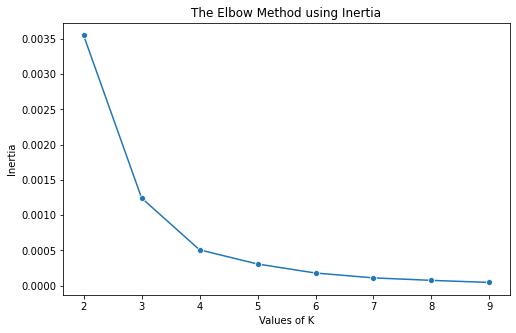

In [24]:
def clustering(data,kclusters: int):
    data_clustering = data
    kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(data_clustering)
    return kmeans_model

k = []
inertia = []

for i in range(2,10):
    data = jap.drop(['Neighborhood'], axis=1)
    model = clustering(data, i)
    
    k.append(i)
    inertia.append(model.inertia_)
    
sns.lineplot(x = k, y=inertia, marker='o', dashes=False)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

It appears that K=4 is the inflection point of the graph hence our optimal K value.   
We use K=4 for the succeeding K=means clustering

### C.3. K-means clustering 

Now we apply the K-means clustering to our dataset. 


In [25]:
kclusters = 4

toronto_grouped_clustering = jap.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 0, 1, 0, 3, 1, 0, 0, 0])

In [26]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [27]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = jap.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

to_merged.head()

,Neighborhood,Japanese Restaurant,Cluster Labels
0,Berczy Park,0.021277,2
1,"Brockton, Parkdale Village, Exhibition Place",0.043478,1
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
3,Central Bay Street,0.048387,1
4,Christie,0.000000,0


In [28]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1505, 9)


,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.021277,2,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.021277,2,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.021277,2,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.021277,2,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar
0,Berczy Park,0.021277,2,43.644771,-79.373306,St. Lawrence Market (South Building),43.648743,-79.371597,Farmers Market


In [29]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(1505, 9)


,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Church and Wellesley,0.074627,3,43.66586,-79.38316,Starbucks,43.664980,-79.380510,Coffee Shop
5,Church and Wellesley,0.074627,3,43.66586,-79.38316,Churchmouse & Firkin,43.664632,-79.380406,Pub
5,Church and Wellesley,0.074627,3,43.66586,-79.38316,Church Street Espresso,43.668292,-79.381877,Café
5,Church and Wellesley,0.074627,3,43.66586,-79.38316,Rooster Coffee House,43.669654,-79.379871,Coffee Shop
5,Church and Wellesley,0.074627,3,43.66586,-79.38316,Fabarnak,43.666377,-79.380964,Restaurant


In [30]:
# Check how many Japanese restaurant entries we have. 
to_merged['Venue Category'].value_counts()['Japanese Restaurant']

38

### C.4. Visualizing the division

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## D. RESULTS

### D.1. The No. of neighborhood per cluster

C:\Users\krojas\localapps\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'No. of Neighborhoods')

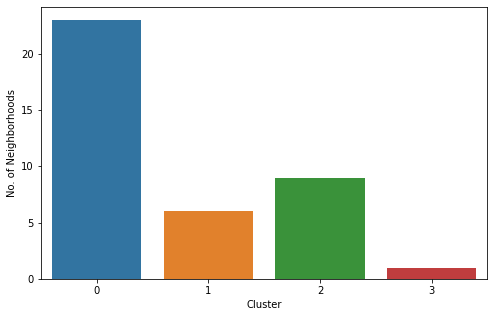

In [32]:
jap["Cluster Labels"] = kmeans.labels_
# ita.head()

objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = jap['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()

# plt.figure(figsize=(8, 4))
ax = sns.barplot(x=y_pos, y=perf)
plt.xlabel("Cluster")
plt.ylabel("No. of Neighborhoods")


In [33]:
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
0,North York,Parkwoods
1,North York,Victoria Village
2,Downtown Toronto,"Regent Park, Harbourfront"
3,North York,"Lawrence Manor, Lawrence Heights"
4,Queen's Park,Ontario Provincial Government


### D.2. Identifying the clusters

In [34]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
cluster1.head()

,Borough,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,Parliament Square Park,43.650264,-79.362195,Park
1,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,Underpass Park,43.655764,-79.354806,Park
2,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,Souvlaki Express,43.655584,-79.364438,Greek Restaurant
3,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,The Aviary,43.653634,-79.354662,Pub
4,Downtown Toronto,"Regent Park, Harbourfront",0.0,0,43.65426,-79.360636,Brick Street Bakery,43.650574,-79.359539,Bakery


In [35]:
cluster2 = to_merged.loc[to_merged['Cluster Labels'] == 1]
cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
cluster2.head()

,Borough,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Central Bay Street,0.048387,1,43.657952,-79.387383,Scaddabush Italian Kitchen & Bar,43.658920,-79.382891,Italian Restaurant
1,Downtown Toronto,Central Bay Street,0.048387,1,43.657952,-79.387383,Midi Bistro,43.655871,-79.392091,French Restaurant
2,Downtown Toronto,Central Bay Street,0.048387,1,43.657952,-79.387383,Zavida Coffee Roasters,43.659692,-79.382638,Coffee Shop
3,Downtown Toronto,Central Bay Street,0.048387,1,43.657952,-79.387383,Pizza Pizza,43.659487,-79.385207,Pizza Place
4,Downtown Toronto,Central Bay Street,0.048387,1,43.657952,-79.387383,freshii,43.661286,-79.383964,Salad Place


In [36]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
cluster3.head()

,Borough,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Garden District, Ryerson",0.03,2,43.657162,-79.378937,Tim Hortons,43.653625,-79.377732,Coffee Shop
1,Downtown Toronto,"Garden District, Ryerson",0.03,2,43.657162,-79.378937,Williams-Sonoma,43.653478,-79.380434,Kitchen Supply Store
2,Downtown Toronto,"Garden District, Ryerson",0.03,2,43.657162,-79.378937,Subway,43.654613,-79.376189,Sandwich Place
3,Downtown Toronto,"Garden District, Ryerson",0.03,2,43.657162,-79.378937,lululemon athletica,43.653286,-79.380764,Clothing Store
4,Downtown Toronto,"Garden District, Ryerson",0.03,2,43.657162,-79.378937,Vans,43.654826,-79.380241,Shoe Store


In [37]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
cluster4

,Borough,Neighborhood,Japanese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Flash,43.664319,-79.380190,Strip Club
1,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,O. Noir,43.669145,-79.382505,Restaurant
2,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Church Street Garage,43.664710,-79.380332,Gay Bar
3,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,H Mart,43.669332,-79.386257,Grocery Store
4,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Sushi Garden,43.664858,-79.384941,Sushi Restaurant
...,...,...,...,...,...,...,...,...,...,...
62,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Starbucks,43.664980,-79.380510,Coffee Shop
63,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Churchmouse & Firkin,43.664632,-79.380406,Pub
64,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Church Street Espresso,43.668292,-79.381877,Café
65,Downtown Toronto,Church and Wellesley,0.074627,3,43.66586,-79.38316,Rooster Coffee House,43.669654,-79.379871,Coffee Shop


### D.3. A closer look into the data

Now we take a closer look, specifically the number of neighborhoods and japanese restaurants per cluster.

Text(0.5, 1.0, 'Average number of Japanese Restaurants per Cluster')

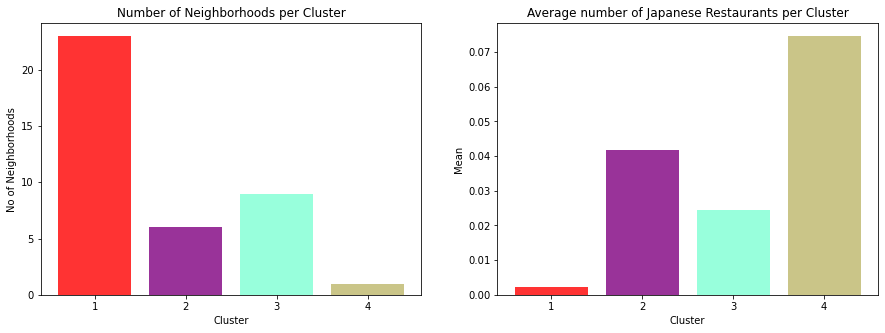

In [38]:

plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = jap['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [cluster1['Japanese Restaurant'].mean(),cluster2['Japanese Restaurant'].mean(),cluster3['Japanese Restaurant'].mean(),
                cluster4['Japanese Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Japanese Restaurants per Cluster')

## E. CONCLUSION

From the perspective of a tourist, it may be best to go to the neighborhoods in cluster 4. There are a lot of Japanese restaurants that will cater to the adventurous pallete. 

From the perspective of a businessman, the optimal location is in cluster 1, where there are a lot of potential demands for a japanese restaurant while having the least competition around the vicinity. Of course it might be possible that these neighborhoods are less commercialize as compared to cluster 4. 
